Tests for Assessement week 5


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns    
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [3]:


df = pd.read_csv('wines_SPA.csv')

# Initial data exploration

# I'm dropping duplicates right away to ensure the statistics are not distorted.
df = df.drop_duplicates()

# Describe numerical columns
print(df.describe())
print()
# Save numerical columns
numerical_columns = df.describe().columns

# I check the number of unique values in the remaining categorical column to understand their variability.
print("Categorical Columns:")
for column in df.columns:
    if column not in numerical_columns:
        print(f"Unique values in '{column}': {len(df[column].unique())}")

# Check for missing values
print("\nMissing Values")
print(df.isna().sum())

            rating   num_reviews        price         body      acidity
count  2048.000000   2048.000000  2048.000000  1777.000000  1777.000000
mean      4.401123    573.994629   135.242194     4.258863     2.921216
std       0.147023   1376.153171   272.178316     0.652836     0.334713
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.300000     58.000000    31.917947     4.000000     3.000000
50%       4.400000    141.000000    53.625000     4.000000     3.000000
75%       4.500000    485.500000   110.000000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000

Categorical Columns:
Unique values in 'winery': 480
Unique values in 'wine': 847
Unique values in 'year': 72
Unique values in 'country': 1
Unique values in 'region': 76
Unique values in 'type': 22

Missing Values
winery           0
wine             0
year             2
rating           0
num_reviews      0
country          0
region           0
price

In [4]:
# Removing columns I do not want to further use.
df = df.drop(columns=['country', 'num_reviews'], axis=1)

# Drop missing values and drop duplicates again
df = df.dropna()

In [5]:


print(df.describe())

print("\nCategorical Columns:")
for column in df.columns:
    if column not in numerical_columns:
        print(f"Unique values in '{column}': {len(df[column].unique())}")

            rating        price         body      acidity
count  1775.000000  1775.000000  1775.000000  1775.000000
mean      4.411887   148.786017     4.258592     2.921690
std       0.150982   289.401877     0.652938     0.334181
min       4.200000     4.990000     2.000000     1.000000
25%       4.300000    33.015000     4.000000     3.000000
50%       4.400000    58.260000     4.000000     3.000000
75%       4.500000   125.000000     5.000000     3.000000
max       4.900000  3119.080000     5.000000     3.000000

Categorical Columns:
Unique values in 'winery': 425
Unique values in 'wine': 738
Unique values in 'year': 71
Unique values in 'region': 66
Unique values in 'type': 21


In [6]:
# Engineering data



# Price
df['price_log'] = np.log(df['price'])

# Year
# First, convert year into a numeric column, all strings will be NaN
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce') 
# Add a column to indicate missing values
df['is_nv'] = (df['year_numeric'].isna()).astype(int) 
# Get the median year for imputing
median_year = df['year_numeric'].median()
# impute
df['year_numeric'] = df['year_numeric'].fillna(median_year)
# calculate age
df['age'] = df['year_numeric'].max() + 1 - df['year_numeric']
# calculate log of age
df['age_log'] = np.log(df['age'])





In [7]:
# find unique values and their counts in categorical columns 
type_counts = df['type'].value_counts()
winery_counts = df['winery'].value_counts()
wine_counts = df['wine'].value_counts()
region_counts = df['region'].value_counts()

# from each remove the ones with less than 175 occurrences
type_to_keep = type_counts[type_counts >= 175].index
winery_to_keep = winery_counts[winery_counts >= 175].index
wine_to_keep = wine_counts[wine_counts >= 175].index
region_to_keep = region_counts[region_counts >= 175].index

# Create a new type column with only the frequent types, others as 'Other'
df['type_r'] = df['type'].where(df['type'].isin(type_to_keep), 'Other')
df['winery_r'] = df['winery'].where(df['winery'].isin(winery_to_keep), 'Other')
df['wine_r'] = df['wine'].where(df['wine'].isin(wine_to_keep), 'Other')
df['region_r'] = df['region'].where(df['region'].isin(region_to_keep), 'Other')           

# One-hot encode categorical variables leaving out the first category to avoid multicollinearity
type_dummies = pd.get_dummies(df['type_r'], prefix='type', drop_first=True)
winery_dummies = pd.get_dummies(df['winery_r'], prefix='winery', drop_first=True)
wine_dummies = pd.get_dummies(df['wine_r'], prefix='wine', drop_first=True)
region_dummies = pd.get_dummies(df['region_r'], prefix='region', drop_first=True)
# Concatenate the new dummy columns to the original dataframe
df = pd.concat([df, type_dummies, winery_dummies, wine_dummies, region_dummies], axis=1)
# save the dummy column names
type_columns = type_dummies.columns.tolist()    
winery_columns = winery_dummies.columns.tolist()
wine_columns = wine_dummies.columns.tolist()
region_columns = region_dummies.columns.tolist()






      price_log   age_log  is_nv  body  type_Priorat Red  type_Red  \
1737   3.806662  3.610918      0   4.0             False     False   
1108   4.752728  1.791759      0   4.0             False      True   
273    5.512420  3.663562      0   5.0             False     False   
148    4.175156  2.397895      0   2.0             False     False   
1876   3.465770  2.079442      0   4.0             False     False   
81     6.700276  3.583519      0   5.0             False     False   
1796   2.737609  1.609438      0   4.0             False      True   
954    4.818344  1.791759      0   4.0             False      True   
1919   2.917771  1.098612      0   5.0             False     False   
510    3.624341  2.302585      0   4.0             False     False   

      type_Ribera Del Duero Red  type_Rioja Red  region_Priorato  \
1737                      False            True            False   
1108                      False           False            False   
273                      

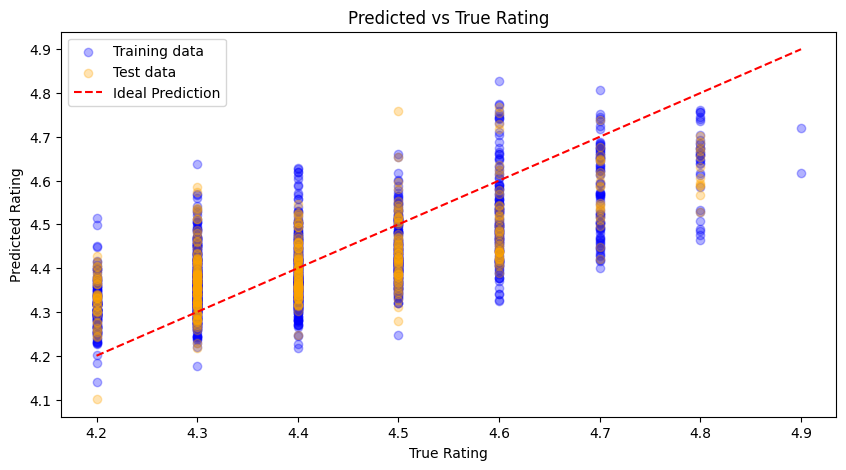

In [8]:
# Create the feature and target dataframes

features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
print(df_features_quality.sample(10))
# I won't scale rating as the values are moderate
df_target_quality = df['rating']


# Use StandardScaler to scale the features

scaler_quality = StandardScaler()
scaler_quality.fit(df_features_quality)
df_features_quality_std = scaler_quality.transform(df_features_quality)

# Create test and training sets
# I will use 80% of the data for training and 20% for testing.

X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(df_features_quality_std, 
                                     df_target_quality,
                                     test_size=0.2, 
                                     random_state=0
                                     )

# Training the LinearRegression models.

lr_quality = LinearRegression()
lr_quality.fit(X_train_quality, y_train_quality)
# Make predictions on training and test sets.
y_pred_quality = lr_quality.predict(X_train_quality)
y_pred_quality_test = lr_quality.predict(X_test_quality)

# Evaluate the models using MAE, RMSE and R^2 score.
mae_quality = mean_absolute_error(y_train_quality, y_pred_quality)
rmse_quality = root_mean_squared_error(y_train_quality, y_pred_quality)
r2_quality = r2_score(y_train_quality, y_pred_quality)
# evaluate the test set as well
mae_quality_test = mean_absolute_error(y_test_quality, y_pred_quality_test)
rmse_quality_test = root_mean_squared_error(y_test_quality, y_pred_quality_test)
r2_quality_test = r2_score(y_test_quality, y_pred_quality_test)
# Print the evaluation metrics.
print("\nQuality Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_quality}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality}")
print(f"R^2 Score: {r2_quality}")
print("\nQuality Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality_test}")
print(f"R^2 Score: {r2_quality_test}")

# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10,5))
plt.scatter(y_train_quality, y_pred_quality, alpha=0.3, color='blue', label='Training data')
plt.scatter(y_test_quality, y_pred_quality_test, alpha=0.3, color='orange', label='Test data')
plt.plot([y_train_quality.min(), y_train_quality.max()], [y_train_quality.min(), y_train_quality.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Rating')
plt.legend()
plt.show()  

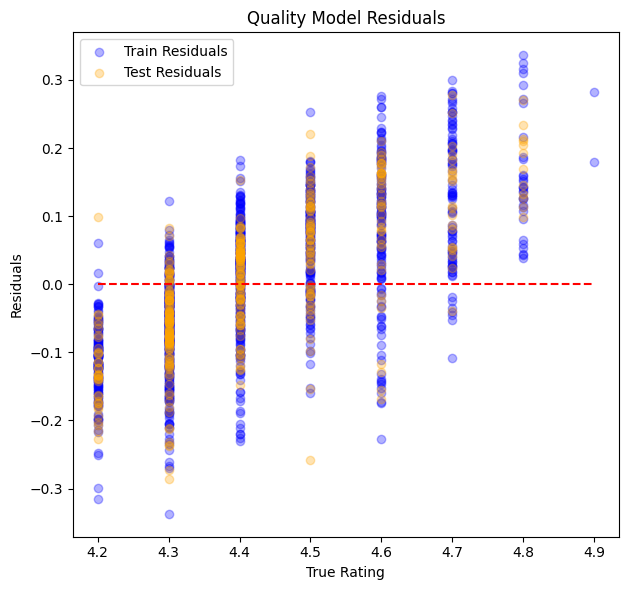

In [9]:
# Residual plots for both models to compare training and test residuals.
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 2)
plt.scatter(y_train_quality, y_train_quality - y_pred_quality, alpha=0.3, color='blue', label='Train Residuals')
plt.scatter(y_test_quality, y_test_quality - y_pred_quality_test, alpha=0.3, color='orange', label='Test Residuals')
plt.hlines(0, y_train_quality.min(), y_train_quality.max(), colors='red', linestyles='--')
plt.xlabel('True Rating')
plt.ylabel('Residuals')
plt.title('Quality Model Residuals')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# I set up K-Fold cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store coefficients from each fold
coefs = []
 
# Target variable in a numpy array
y = df_target_quality.values

# Perform K-Fold cross-validation
for train_idx, test_idx in kf.split(df_features_quality_std):
    X_train, X_test = df_features_quality_std[train_idx], df_features_quality_std[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    coefs.append(model.coef_)

# Convert to DataFrame for analysis
coefs_df = pd.DataFrame(coefs, columns=features_quality_columns)

# Analyze mean and std deviation of coefficients across folds
coef_summary = pd.DataFrame({
    'mean_coef': coefs_df.mean(),
    'std_coef': coefs_df.std(),
    'abs_mean': coefs_df.mean().abs()
}).sort_values('abs_mean', ascending=False)

# Calculate the coefficient of variation for each model coefficient (i.e. for each feature)
# by dividing the standard deviation of the coefficients by the absolute means (i.e. the variations across the folds).
# Add a small number (epsilon) just so there is no division by zero
epsilon = 1e-6
cv = coef_summary['std_coef'] / (coef_summary['abs_mean'] + epsilon)
# for each feature, check if the feature coefficient does not always have the same sign across the folds.
sign_flips = coefs_df.apply(np.sign, axis=0).nunique() > 1

# Define thresholds for stability
# cv: if cv >1, the variance is higher than the mean, so the feature is unstable
# abs_mean: if the abs(coefficient) is very small, the feature is not important
cv_threshold = 1.0
abs_mean_threshold = 0.01

# Calculate stability mask:
# cv under the threshold, abs_mean above the threshold, and no sign flips
stable_mask = (cv < cv_threshold) & (coef_summary['abs_mean'] > abs_mean_threshold) & (~sign_flips)

# Add Stable column
coef_summary['Stable'] = stable_mask

print("RESULTS FOR QUALITY MODEL\n")
pd.set_option('display.max_rows', 1300)  # Or use 1250 exactly

print(coef_summary)


RESULTS FOR QUALITY MODEL

                           mean_coef  std_coef  abs_mean  Stable
price_log                   0.116888  0.002347  0.116888    True
type_Priorat Red           -0.037563  0.031525  0.037563   False
age_log                    -0.025685  0.001209  0.025685    True
region_Rioja               -0.017350  0.001167  0.017350    True
region_Priorato             0.016953  0.031805  0.016953   False
is_nv                      -0.006347  0.001261  0.006347   False
region_Ribera del Duero     0.005754  0.003349  0.005754   False
type_Ribera Del Duero Red  -0.004247  0.004886  0.004247   False
body                        0.003377  0.001239  0.003377   False
type_Rioja Red              0.003220  0.001794  0.003220   False
type_Red                   -0.001215  0.001367  0.001215   False


**Try other models**

Best alpha: 0.006579332246575682
Best l1_ratio: 0.1

Quality Model Evaluation (Training Set):
Mean Absolute Error (MAE): 0.08570447237596497
Root Mean Squared Error (RMSE): 0.10580287490576351
R^2 Score: 0.5048951558252406

Quality Model Test Set Evaluation:
Mean Absolute Error (MAE): 0.0886109730195357
Root Mean Squared Error (RMSE): 0.10819121368025755
R^2 Score: 0.4999371815596002


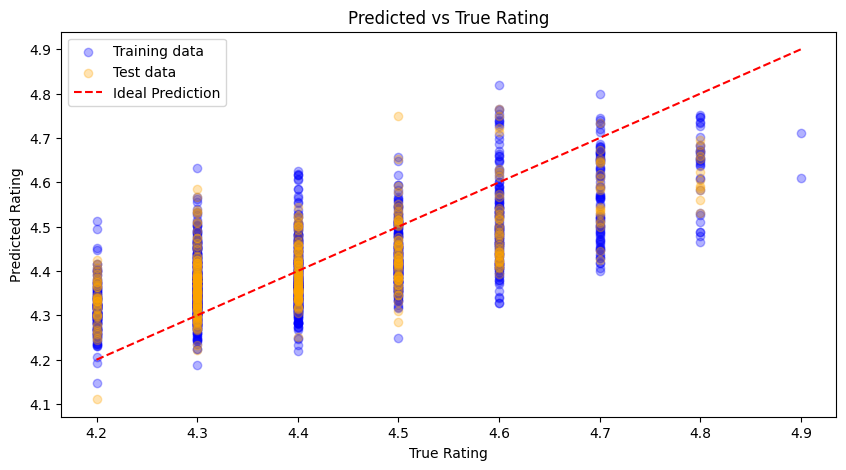

In [11]:
# make a elastic Net model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV


# Create the feature and target dataframes

features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
# I won't scale rating as the values are moderate
df_target_quality = df['rating']


# Use StandardScaler to scale the features

scaler_quality = StandardScaler()
scaler_quality.fit(df_features_quality)
df_features_quality_std = scaler_quality.transform(df_features_quality)

# Create test and training sets
# I will use 80% of the data for training and 20% for testing.

X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(df_features_quality_std, 
                                     df_target_quality,
                                     test_size=0.2, 
                                     random_state=0
                                     )

# Training the LinearRegression models.




# Define a range of alpha and l1_ratio values to test
model_cv = ElasticNetCV(
    alphas=np.logspace(-4, 2, 100),     # Try alpha from 1e-4 to 1e2
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0], # Try different l1_ratio values
    cv=5,                               # 5-fold cross-validation
    random_state=42
)

# Fit the model
model_cv.fit(X_train_quality, y_train_quality)

print("Best alpha:", model_cv.alpha_)
print("Best l1_ratio:", model_cv.l1_ratio_)




lr_quality = ElasticNet(alpha=model_cv.alpha_, l1_ratio=model_cv.l1_ratio_, random_state=42)
lr_quality.fit(X_train_quality, y_train_quality)
# Make predictions on training and test sets.
y_pred_quality = lr_quality.predict(X_train_quality)
y_pred_quality_test = lr_quality.predict(X_test_quality)

# Evaluate the models using MAE, RMSE and R^2 score.
mae_quality = mean_absolute_error(y_train_quality, y_pred_quality)
rmse_quality = root_mean_squared_error(y_train_quality, y_pred_quality)
r2_quality = r2_score(y_train_quality, y_pred_quality)
# evaluate the test set as well
mae_quality_test = mean_absolute_error(y_test_quality, y_pred_quality_test)
rmse_quality_test = root_mean_squared_error(y_test_quality, y_pred_quality_test)
r2_quality_test = r2_score(y_test_quality, y_pred_quality_test)
# Print the evaluation metrics.
print("\nQuality Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_quality}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality}")
print(f"R^2 Score: {r2_quality}")
print("\nQuality Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality_test}")
print(f"R^2 Score: {r2_quality_test}")

# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10,5))
plt.scatter(y_train_quality, y_pred_quality, alpha=0.3, color='blue', label='Training data')
plt.scatter(y_test_quality, y_pred_quality_test, alpha=0.3, color='orange', label='Test data')
plt.plot([y_train_quality.min(), y_train_quality.max()], [y_train_quality.min(), y_train_quality.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Rating')
plt.legend()
plt.show()  



# CLUSTERING

## K-MEANS

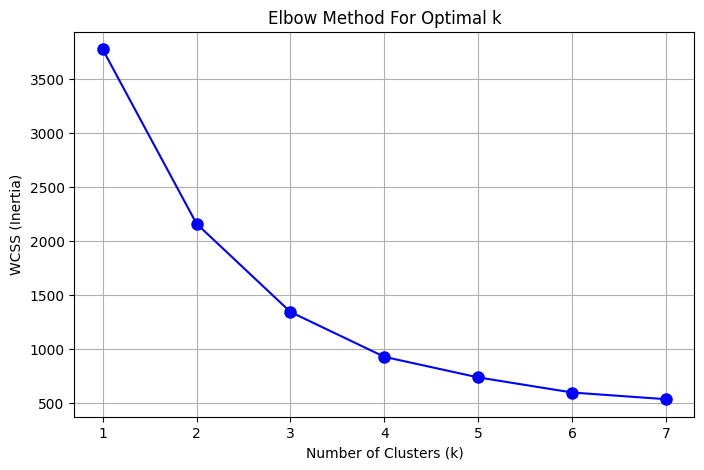

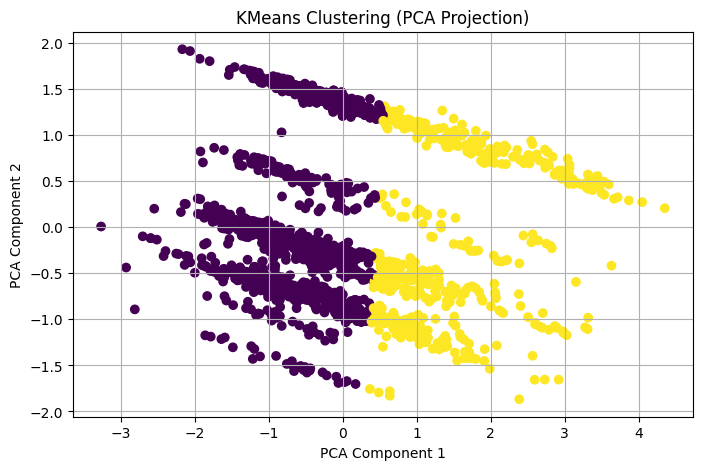

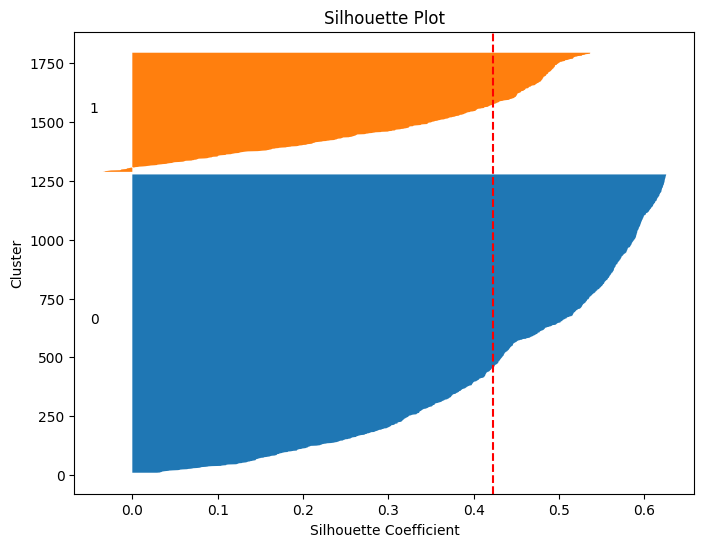

In [67]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]

# Use StandardScaler to scale the features

scaler_quality = StandardScaler()
scaler_quality.fit(df_features_quality)
df_features_quality_std = scaler_quality.transform(df_features_quality)


# Create an elbow curve to identify the best number of clusters for L-means++

X = df_features_quality.values 

# Dimensionality reduction

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_features_quality)




wcss = []
k_values = range(1, 8)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

n_clusters=2
# Fit KMeans
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X_pca)



plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("KMeans Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

sil_vals = silhouette_samples(X_pca, labels)
y_lower = 10

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    cluster_sil_vals = sil_vals[labels == i]
    cluster_sil_vals.sort()
    size_cluster = cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_sil_vals)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10

plt.axvline(np.mean(sil_vals), color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot")
plt.show()



## DBSCAN

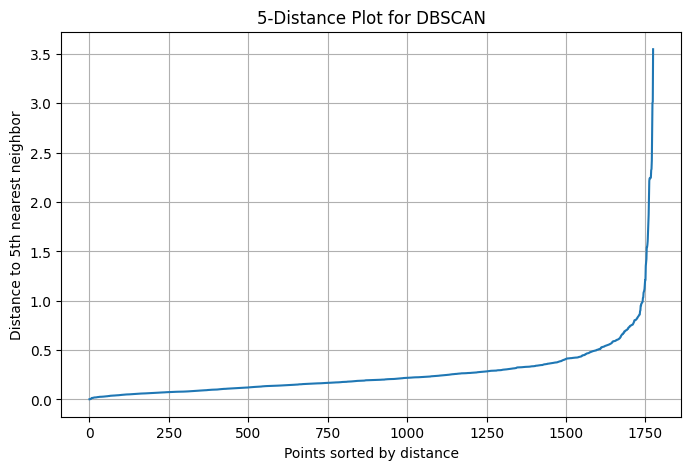

In [30]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Scale the data first!
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(df_features_quality)

# Compute distances to the k-th nearest neighbor (e.g. k = min_samples = 5)
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to the k-th neighbor
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title(f"{k}-Distance Plot for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.grid(True)
plt.show()


In [43]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3., min_samples=5)  # Replace 0.5 with value from k-distance plot
labels = dbscan.fit_predict(X_scaled)


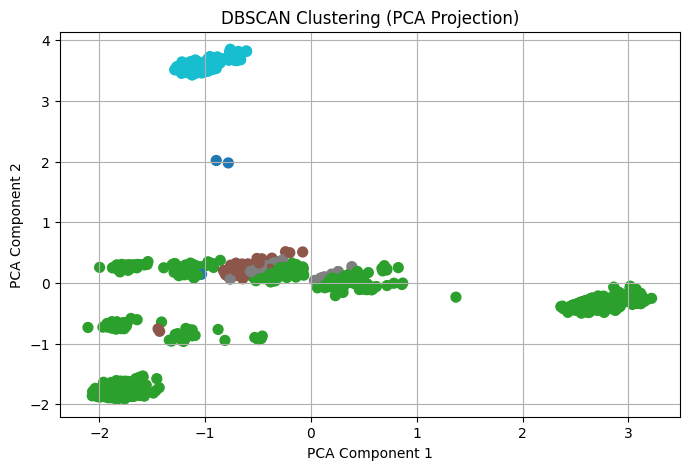

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=50)
plt.title("DBSCAN Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


## Supervised: Random Forest ##



Accuracy: 0.3014

Classification Report:
              precision    recall  f1-score   support

         4.2       0.34      0.30      0.32        40
         4.3       0.38      0.42      0.40       107
         4.4       0.18      0.22      0.20        73
         4.5       0.35      0.24      0.29        74
         4.6       0.26      0.24      0.25        37
         4.7       0.31      0.26      0.29        19
         4.8       0.20      0.40      0.27         5

    accuracy                           0.30       355
   macro avg       0.29      0.30      0.29       355
weighted avg       0.31      0.30      0.30       355



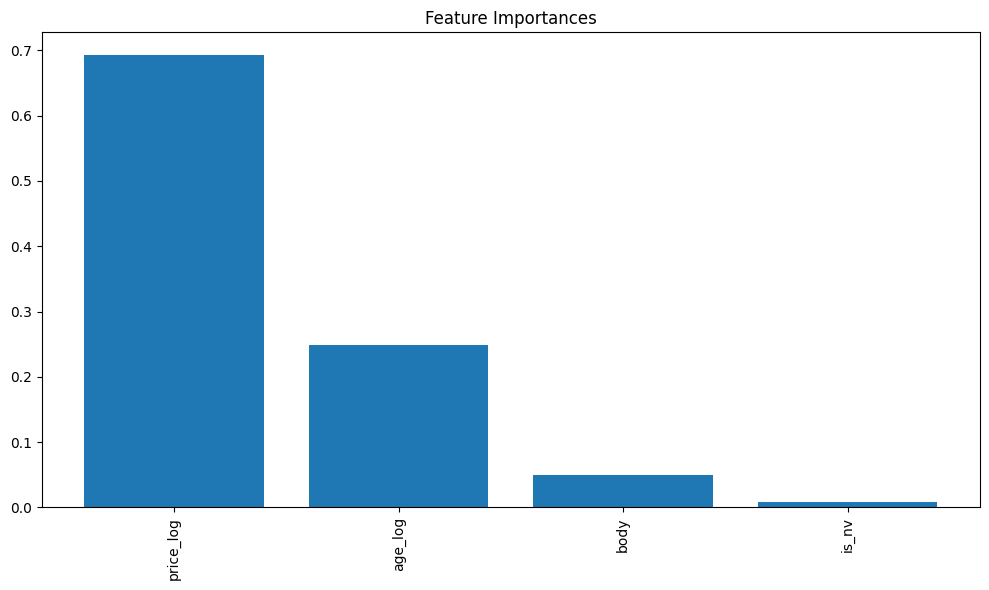

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Assuming:
# - df_features_quality is your DataFrame with features
# - y is your array/Series with labels

# 1. Extract features and labels
features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] #+ type_columns #+ winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
X = df_features_quality.values  # Convert DataFrame to numpy array
# y is your label vector
y_str = df_target_quality.astype(str)

# 2. Scale features (recommended for many models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_str, test_size=0.2, random_state=42
)

# 4. Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. Predict on test data
y_pred = rf.predict(X_test)

# 6. Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Optional: Feature importance
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df_features_quality.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


## PCA Eigenvalue analysis

(1775, 11)


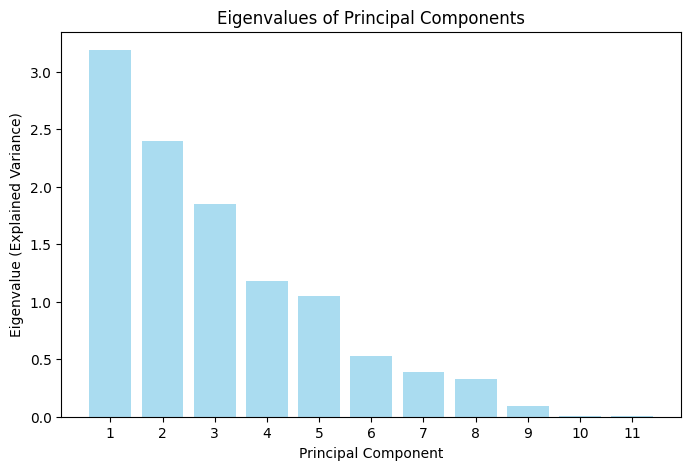

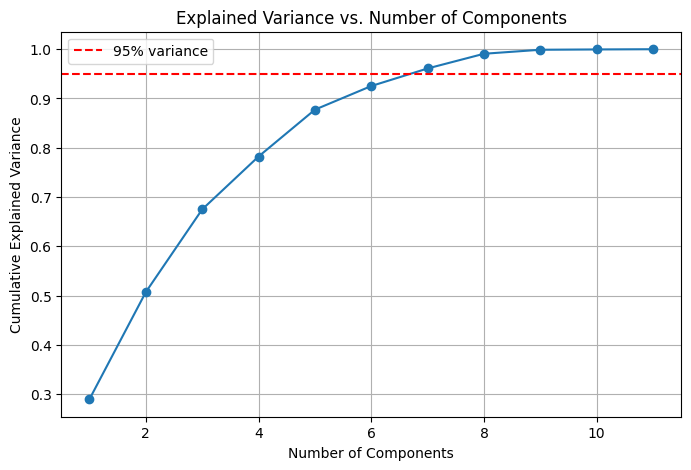

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load example dataset
features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
X = df_features_quality.values  # Convert DataFrame to numpy array

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Eigenvalues are the explained variance
eigenvalues = pca.explained_variance_

# Plot eigenvalues
plt.figure(figsize=(8,5))
plt.bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.7, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Eigenvalues of Principal Components')
plt.xticks(range(1, len(eigenvalues)+1))
plt.show()

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load example dataset
features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
X = df_features_quality.values  # Convert DataFrame to numpy array
df_target_quality = df['rating']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Fit PCA
pca = PCA(n_components=7)
X_reduced = pca.fit_transform(X_scaled)

# Create test and training sets
# I will use 80% of the data for training and 20% for testing.

X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(X_reduced, 
                                     df_target_quality,
                                     test_size=0.2, 
                                     random_state=0
                                     )

# Training the LinearRegression models.

lr_quality = LinearRegression()
lr_quality.fit(X_train_quality, y_train_quality)
# Make predictions on training and test sets.
y_pred_quality = lr_quality.predict(X_train_quality)
y_pred_quality_test = lr_quality.predict(X_test_quality)

# Evaluate the models using MAE, RMSE and R^2 score.
mae_quality = mean_absolute_error(y_train_quality, y_pred_quality)
rmse_quality = root_mean_squared_error(y_train_quality, y_pred_quality)
r2_quality = r2_score(y_train_quality, y_pred_quality)
# evaluate the test set as well
mae_quality_test = mean_absolute_error(y_test_quality, y_pred_quality_test)
rmse_quality_test = root_mean_squared_error(y_test_quality, y_pred_quality_test)
r2_quality_test = r2_score(y_test_quality, y_pred_quality_test)

print("\nQuality Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_quality}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality}")
print(f"R^2 Score: {r2_quality}")
print("\nQuality Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality_test}")
print(f"R^2 Score: {r2_quality_test}")


Quality Model Evaluation (Training Set):
Mean Absolute Error (MAE): 0.08552555063330355
Root Mean Squared Error (RMSE): 0.1059603617046532
R^2 Score: 0.5034201390485824

Quality Model Test Set Evaluation:
Mean Absolute Error (MAE): 0.08880299282031842
Root Mean Squared Error (RMSE): 0.10822214752699845
R^2 Score: 0.4996511864685734


## t-SNE

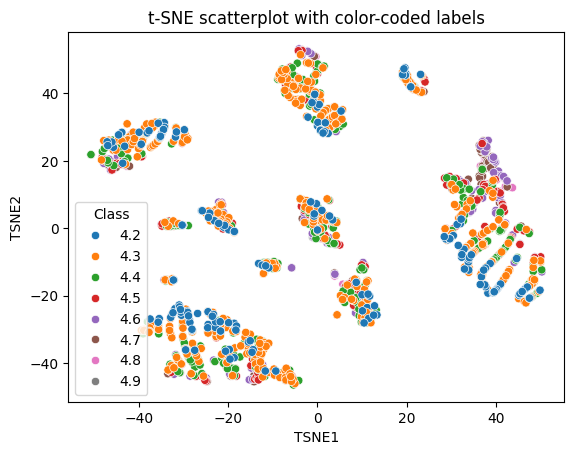

In [78]:
from sklearn.manifold import TSNE

features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
X = df_features_quality.values  # Convert DataFrame to numpy array
df_target_quality = df['rating']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, init='pca', random_state=1)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'label': df_target_quality
})

# Plot with seaborn scatterplot and color by label
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='label', palette='tab10', legend='full')

plt.title('t-SNE scatterplot with color-coded labels')
plt.legend(title='Class')
plt.show()


### t-SNE with UMAP, LDA

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from umap import UMAP
import umap
print(dir(umap))  # Should list 'UMAP' among the attributes

X = X_scaled
y = df_target_quality.astype(str)


# 1. Compute LDA embedding (2D)
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# 2. Compute UMAP embedding (2D)
reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# 3. Compute t-SNE initialized with LDA embedding
tsne_lda = TSNE(n_components=2, init=X_lda, random_state=42, n_iter=1000)
X_tsne_lda_init = tsne_lda.fit_transform(X)

# 4. Compute t-SNE initialized with UMAP embedding
tsne_umap = TSNE(n_components=2, init=X_umap, random_state=42, n_iter=1000)
X_tsne_umap_init = tsne_umap.fit_transform(X)

# Prepare DataFrames for plotting
def make_df(X_emb, labels, name):
    return pd.DataFrame({
        'Dim1': X_emb[:, 0],
        'Dim2': X_emb[:, 1],
        'label': labels.astype(str),
        'method': name
    })

df_lda = make_df(X_lda, y, 'LDA')
df_umap = make_df(X_umap, y, 'UMAP')
df_tsne_lda = make_df(X_tsne_lda_init, y, 't-SNE init LDA')
df_tsne_umap = make_df(X_tsne_umap_init, y, 't-SNE init UMAP')

# Plotting function
def plot_embedding(df, title):
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='label', palette='tab10', s=60)
    plt.title(title)
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()

# Plot each
plot_embedding(df_lda, 'LDA Embedding')
plot_embedding(df_umap, 'UMAP Embedding')
plot_embedding(df_tsne_lda, 't-SNE initialized with LDA')
plot_embedding(df_tsne_umap, 't-SNE initialized with UMAP')


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


NameError: name 'UMAP' is not defined